<a href="https://colab.research.google.com/github/mikemiller97/disaster-prediction/blob/main/nlp_disaster_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets
>Predict which Tweets are about real disasters and which ones are not

## 1. Problem Definition

The following description is taken from the [Kaggle competition page](https://www.kaggle.com/competitions/nlp-getting-started/overview)
>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

>In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

## 2. Data
>The data has been taken from the same Kaggle competition. The data has been broken down into a testing and training set with a sample submission file.

## 3. Features

|Variable | Definition|
|----------|------------|
|id | a unique identifier for each tweet|
|text | the text of the tweet|
|location | the location the tweet was sent from (may be blank)|
|keyword | a particular keyword from the tweet (may be blank)|
|target | in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)|


## Imports

In [1]:
!pip install transformers datasets

In [2]:
#Preparing preprocessing model
!pip install tensorflow_text

In [3]:
!pip install keras-nlp

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import tensorflow as tf
import os

import tensorflow_text as text
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_nlp
from sklearn.ensemble import RandomForestClassifier

## Data Exploration

In [6]:
def read_csv_with_check(file_path, **kwargs):
    """
    Reads a CSV file if it exists, otherwise raises FileNotFoundError.

    Parameters:
    - file_path (str): The path to the CSV file.
    - **kwargs: Additional keyword arguments to be passed to pandas.read_csv.

    Returns:
    - DataFrame: A pandas DataFrame containing the data from the CSV file.

    Raises:
    - FileNotFoundError: If the specified file_path does not exist.
    """
    if os.path.exists(file_path):
        return pd.read_csv(file_path, **kwargs)
    else:
        raise FileNotFoundError(f"The file {file_path} does not exist.")


In [7]:
#Bringing in the training and test data

file_path = "/content/drive/MyDrive/nlp-disaster-classification/train.csv"
try:
    train = read_csv_with_check(file_path, index_col="id")
except FileNotFoundError as e:
    print(e)

file_path = "/content/drive/MyDrive/nlp-disaster-classification/test.csv"
try:
    test = read_csv_with_check(file_path, index_col="id")
except FileNotFoundError as e:
    print(e)

In [8]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
train.columns

Index(['keyword', 'location', 'text', 'target'], dtype='object')

In [11]:
train.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

In [12]:
train.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

>Interesting so far! It looks like the columns will have to be transformed to fit the models and there are some missing values in the keywork and location columns.

>I will now make a graph to visualize how the training data is split between disaster tweets and non-disaster tweets.

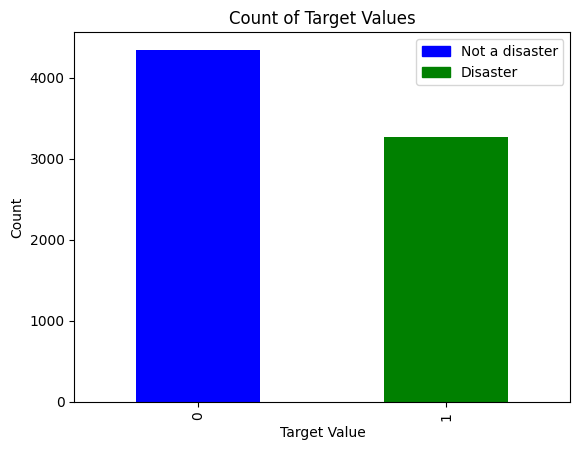

In [13]:
result = train.groupby("target").size()

# Create a bar graph with custom colors
ax = result.plot(kind="bar", color=["blue", "green"])

# Adding labels and title
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.title("Count of Target Values")

# Create colored patches for the legend
colors = ["blue", "green"]
labels = ["Not a disaster", "Disaster"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(colors))]

# Adding custom legend with colored patches
ax.legend(handles=patches)

# Display the plot
plt.show()


>It seems that there are more non-disaster tweets, but overall I feel there isn a large enough sample size of both kinds of tweets to train a reliable model.

In [14]:
train.sample(n=10)

,keyword,location,text,target
id,,,,
1909,burning,"Spokane, Washington 99206",Parents are taking their kids to Burning Man a...,0
4964,explosion,NaN,Another Mechanical Mod Explosion: Man Injured ...,1
3523,derailment,Chicagoland,CHICAGO FD\nSTILL &amp; BOX ALARM/EMS PLAN I \...,1
9395,survivors,NaN,Dying with debt can be costly for survivors,0
8934,snowstorm,Porthcawl,I liked a @YouTube video http://t.co/z8Cp77lVz...,1
1735,buildings%20burning,"Denver, Colorado",The Rocky Fire burning in northern California ...,1
310,annihilated,Boston,Cop pulls drunk driver to safety SECONDS befor...,1
9388,survived,"Austin, TX",Survived Spanish!! @ Sweet Ritual https://t.co...,0
3747,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0


## Preparing Data

>It appears that there are more non-disaster than disaster tweets, but there is still a good amount of both. The first step to preparing the data for a ML model will be filling the missing data in the keyword and location columns.

In [15]:
train_copy = train.copy()

In [16]:
train_copy.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
#Filling missing location and keyword data
fill_value = "Unknown"

missing_location = train_copy["location"].isna()
missing_keyword = train_copy["keyword"].isna()

train_copy.loc[missing_location, "location"] = fill_value
train_copy.loc[missing_keyword, "keyword"] = fill_value

In [18]:
train_copy.head()

,keyword,location,text,target
id,,,,
1,Unknown,Unknown,Our Deeds are the Reason of this #earthquake M...,1
4,Unknown,Unknown,Forest fire near La Ronge Sask. Canada,1
5,Unknown,Unknown,All residents asked to 'shelter in place' are ...,1
6,Unknown,Unknown,"13,000 people receive #wildfires evacuation or...",1
7,Unknown,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
train_copy.sample(n=10)

,keyword,location,text,target
id,,,,
2306,collapse,"Highland Park, CA",Time collapse is such a cool video technique. ...,0
3428,derail,London,Don't let the #tubestrike derail your mood and...,0
7463,obliteration,Unknown,@tiggr_ why only Squad Obliteration?,1
567,arson,Unknown,Trial Date Set for Man Charged with Arson Burg...,1
6622,inundated,"Manchester, England",@teahivetweets You would get inundated!!,0
4030,disaster,"Fort Worth, Texas",What the hell is wrong with people?!communicat...,0
10409,whirlwind,Stamford & Cork (& Shropshire),I moved to England five years ago today. What ...,1
10496,wildfire,Australia,NowPlaying GT &amp; Wildfire feat. Freaks In L...,0
5641,flooding,Huntsville AL,There some flash flooding in madison #valleywx,1


In [20]:
train_copy.isna().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

>Now that all the data has been filled, it still needs to be converted to numbers and embedded when necessary.

In [21]:
train_copy.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

In [22]:
#First, I will one hot encode the keyword and location columns
columns_to_encode = ['keyword', 'location']

train_copy = pd.get_dummies(train_copy, columns=columns_to_encode)

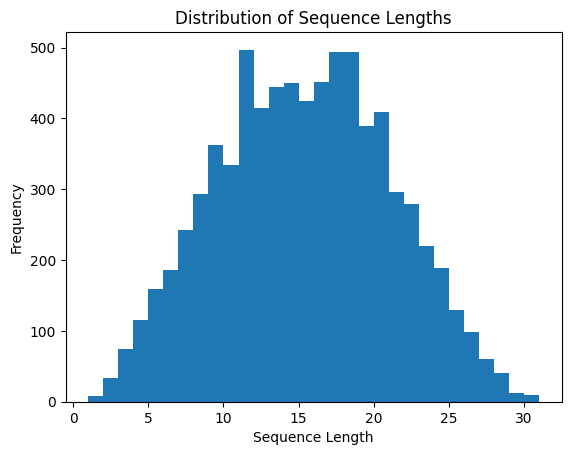

In [23]:
#Lets find a good padding value for vectorization!

text_data = train_copy["text"]

# Calculate the lengths of each sequence (number of tokens)
sequence_lengths = text_data.apply(lambda x: len(x.split()))

# Create a histogram
plt.hist(sequence_lengths, bins=30)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()

>I love it when the distribution becomes a nice Gaussian  cruve. It looks like a sequence length somewhere between 25 and 30 should cover most of the tweets, but lets get a better idea of what to use next.

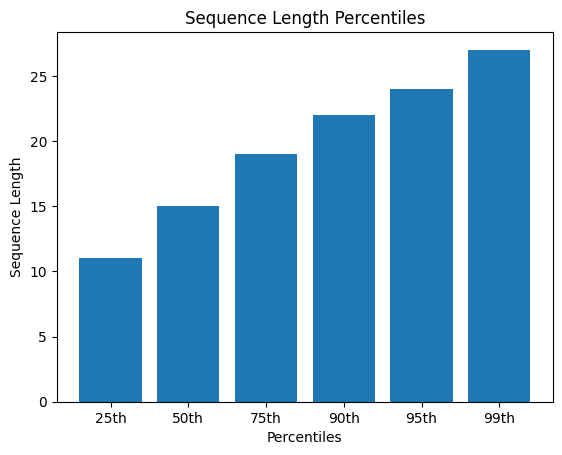

In [24]:
text_data= train_copy["text"]

# Calculate the lengths of each sequence (number of tokens)
sequence_lengths = text_data.apply(lambda x: len(x.split()))

# Calculate percentiles
percentiles = np.percentile(sequence_lengths, [25, 50, 75, 90, 95, 99])

# Print percentiles
plt.bar(range(len(percentiles)), percentiles)
plt.xticks(range(len(percentiles)), [f"{p}th" for p in [25, 50, 75, 90, 95, 99]])
plt.xlabel("Percentiles")
plt.ylabel("Sequence Length")
plt.title("Sequence Length Percentiles");

>I will use 25 as this captures almost all of the tweets

In [25]:
#Now, I will embed the text so a NLP can be used on it. First the vectorization layer
vectorizer =  tf.keras.layers.TextVectorization(max_tokens=1000,
                                                standardize='lower_and_strip_punctuation',
                                                output_mode='int',
                                                pad_to_max_tokens=True,
                                                output_sequence_length=25)

In [26]:
vectorizer.adapt(train_copy["text"])

In [27]:
#Now the embedding layer

embedding_layer = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                            output_dim=128)

## Split data into training and validation sets

In [28]:
X = train_copy["text"]
y = train_copy["target"]

In [29]:
X.shape, y.shape

((7613,), (7613,))

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

In [31]:
X_train.shape, y_train.shape

((6090,), (6090,))

In [32]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [60]:
def make_preds(model_name):
  model = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/' + model_name)

  preds = model.predict(X_val)

  #reshaping array to fit in comparison function below
  preds = np.argmax(preds, axis=1)

  results = calculate_results(y_true=y_val,
                              y_pred=preds)
  print(results)

  return results

In [47]:
# Creating a dictionary to hold the results of all the models
model_scores = {}

## Baseline Model (SKL)

In [43]:
#create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

#fit pipeline to training data
model_0_history = model_0.fit(X=X_train,
                              y=y_train)

In [44]:
#Evaluate baseline model
baseline_score = model_0.score(X_val, y_val)
baseline_score

0.7997373604727511

In [48]:
model_0_preds = model_0.predict(X_val)

model_0_results = calculate_results(y_val, model_0_preds)

model_0_results

{'accuracy': 79.97373604727511,
 'precision': 0.8102693639254774,
 'recall': 0.7997373604727511,
 'f1': 0.7932459520374361}

In [49]:
model_scores["SKL"] = model_0_results

model_scores

{'SKL': {'accuracy': 79.97373604727511,
  'precision': 0.8102693639254774,
  'recall': 0.7997373604727511,
  'f1': 0.7932459520374361}}

## Transfer Learning Model (BERT Tiny)
>BERT's model takes in plain text to interpret so it will be passed the initial version of the text before any vectorization or embedding.

>https://keras.io/api/keras_nlp/models/bert/bert_classifier/

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_1.keras", save_best_only=True)


# Load architecture and weights from preset
model_1 = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased", num_classes=2)

# Load randomly initialized model from preset architecture
model_1_history = model_1.fit(x=X_train,
                              y=y_train,
                              batch_size=16,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

100%|██████████| 507/507 [00:00<00:00, 318kB/s]
100%|██████████| 16.8M/16.8M [00:00<00:00, 21.3MB/s]
100%|██████████| 547/547 [00:00<00:00, 607kB/s]
100%|██████████| 226k/226k [00:00<00:00, 998kB/s] 


Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 186s 308ms/step - loss: 0.6083 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.4507 - val_sparse_categorical_accuracy: 0.8024
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.4573 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.4057 - val_sparse_categorical_accuracy: 0.8319
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 0.3850 - sparse_categorical_accuracy: 0.8338 - val_loss: 0.3997 - val_sparse_categorical_accuracy: 0.8293
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: 0.3255 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8345
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.4488 - val_sparse_categorical_accuracy: 0.8168
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9150 - val_loss: 0.4858 - val_sparse_categorical_accurac

In [50]:
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_1.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [51]:
model_1_preds = model_1.predict(test["text"])

#reshaping array to fit in comparison function below
model_1_preds = np.argmax(model_1_preds, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step


In [52]:
model_1_preds.shape

(3263,)

In [62]:
model_1_preds = make_preds("model_1.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
{'accuracy': 82.9284307288247, 'precision': 0.8293444618354476, 'recall': 0.8292843072882469, 'f1': 0.8279800884040511}


In [63]:
model_scores["BERT Tiny"] = model_1_preds

model_scores

{'SKL': {'accuracy': 79.97373604727511,
  'precision': 0.8102693639254774,
  'recall': 0.7997373604727511,
  'f1': 0.7932459520374361},
 'BERT Tiny': {'accuracy': 82.9284307288247,
  'precision': 0.8293444618354476,
  'recall': 0.8292843072882469,
  'f1': 0.8279800884040511}}

>It looks like BERT is outperforming the traditional machine learning model. Lets see if a bigger version of BERT will do even better!

## BERT Small Sized

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras", save_best_only=True)


# Load architecture and weights from preset
model_2 = keras_nlp.models.BertClassifier.from_preset("bert_small_en_uncased", num_classes=2)

# Load randomly initialized model from preset architecture
model_2_history = model_2.fit(x=X_train,
                              y=y_train,
                              batch_size=16,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

100%|██████████| 508/508 [00:00<00:00, 1.20MB/s]
100%|██████████| 110M/110M [00:03<00:00, 37.5MB/s]
100%|██████████| 547/547 [00:00<00:00, 319kB/s]
100%|██████████| 226k/226k [00:00<00:00, 1.00MB/s]


Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 243s 443ms/step - loss: 0.5139 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.4123 - val_sparse_categorical_accuracy: 0.8267
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 101s 265ms/step - loss: 0.3504 - sparse_categorical_accuracy: 0.8580 - val_loss: 0.4283 - val_sparse_categorical_accuracy: 0.8286
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 103s 270ms/step - loss: 0.2510 - sparse_categorical_accuracy: 0.9023 - val_loss: 0.4914 - val_sparse_categorical_accuracy: 0.8280
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 108s 282ms/step - loss: 0.1828 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.6577 - val_sparse_categorical_accuracy: 0.7899


In [64]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras')

model_2_preds = make_preds("model_2.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 148 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step
{'accuracy': 82.66579120157583, 'precision': 0.845665845020169, 'recall': 0.8266579120157583, 'f1': 0.8197693010829347}


In [65]:
model_scores["BERT Small"] = model_2_preds

model_scores

{'SKL': {'accuracy': 79.97373604727511,
  'precision': 0.8102693639254774,
  'recall': 0.7997373604727511,
  'f1': 0.7932459520374361},
 'BERT Tiny': {'accuracy': 82.9284307288247,
  'precision': 0.8293444618354476,
  'recall': 0.8292843072882469,
  'f1': 0.8279800884040511},
 'BERT Small': {'accuracy': 82.66579120157583,
  'precision': 0.845665845020169,
  'recall': 0.8266579120157583,
  'f1': 0.8197693010829347}}

## Hypertuning BERT

>It looks like BERT Tiny and BERT Small both have very comparable scores. Now lets try hypertuning the BERT Small model.

In [ ]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 148 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model_3.layers

[<InputLayer name=padding_mask, built=True>,
 <InputLayer name=segment_ids, built=True>,
 <InputLayer name=token_ids, built=True>,
 <BertBackbone name=bert_backbone, built=True>,
 <Dropout name=classifier_dropout, built=True>,
 <Dense name=logits, built=True>]

In [ ]:
bert_backbone = model_3.layers[3]
bert_layers = bert_backbone.layers
bert_layers

[<InputLayer name=token_ids, built=True>,
 <ReversibleEmbedding name=token_embedding, built=True>,
 <InputLayer name=segment_ids, built=True>,
 <PositionEmbedding name=position_embedding, built=True>,
 <Embedding name=segment_embedding, built=True>,
 <Add name=embeddings_add, built=True>,
 <LayerNormalization name=embeddings_layer_norm, built=True>,
 <Dropout name=embeddings_dropout, built=True>,
 <InputLayer name=padding_mask, built=True>,
 <TransformerEncoder name=transformer_layer_0, built=True>,
 <TransformerEncoder name=transformer_layer_1, built=True>,
 <TransformerEncoder name=transformer_layer_2, built=True>,
 <TransformerEncoder name=transformer_layer_3, built=True>,
 <Dense name=pooled_dense, built=True>]

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  print(layer_number, layer.name, layer.trainable)

0 token_ids True
1 token_embedding True
2 segment_ids True
3 position_embedding True
4 segment_embedding True
5 embeddings_add True
6 embeddings_layer_norm True
7 embeddings_dropout True
8 padding_mask True
9 transformer_layer_0 True
10 transformer_layer_1 True
11 transformer_layer_2 True
12 transformer_layer_3 True
13 pooled_dense True


In [ ]:
#Testing how the model will do if all these layers are false
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_3.keras", save_best_only=True)


# Load architecture and weights from preset
model_3 = keras_nlp.models.BertClassifier.from_preset("bert_small_en_uncased", num_classes=2)

In [ ]:
model_3.layers

[<InputLayer name=padding_mask, built=True>,
 <InputLayer name=segment_ids, built=True>,
 <InputLayer name=token_ids, built=True>,
 <BertBackbone name=bert_backbone, built=True>,
 <Dropout name=classifier_dropout, built=True>,
 <Dense name=logits, built=True>]

In [ ]:
bert_backbone = model_3.layers[3]
bert_layers = bert_backbone.layers
bert_layers

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  print(layer_number, layer.name, layer.trainable)

0 token_ids True
1 token_embedding True
2 segment_ids True
3 position_embedding True
4 segment_embedding True
5 embeddings_add True
6 embeddings_layer_norm True
7 embeddings_dropout True
8 padding_mask True
9 transformer_layer_0 True
10 transformer_layer_1 True
11 transformer_layer_2 True
12 transformer_layer_3 True
13 pooled_dense True


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  layer.trainable = False

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  print(layer_number, layer.name, layer.trainable)

0 token_ids False
1 token_embedding False
2 segment_ids False
3 position_embedding False
4 segment_embedding False
5 embeddings_add False
6 embeddings_layer_norm False
7 embeddings_dropout False
8 padding_mask False
9 transformer_layer_0 False
10 transformer_layer_1 False
11 transformer_layer_2 False
12 transformer_layer_3 False
13 pooled_dense False


In [ ]:
# Load randomly initialized model from preset architecture
model_3_history = model_3.fit(x=X_train,
                              y=y_train,
                              batch_size=16,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 103s 185ms/step - loss: 0.6616 - sparse_categorical_accuracy: 0.5974 - val_loss: 0.6123 - val_sparse_categorical_accuracy: 0.7203
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - loss: 0.6069 - sparse_categorical_accuracy: 0.7043 - val_loss: 0.5794 - val_sparse_categorical_accuracy: 0.7531
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 101s 264ms/step - loss: 0.5822 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.5586 - val_sparse_categorical_accuracy: 0.7676
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - loss: 0.5656 - sparse_categorical_accuracy: 0.7346 - val_loss: 0.5435 - val_sparse_categorical_accuracy: 0.7787
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - loss: 0.5518 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.5322 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - loss: 0.5457 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.5236 - val_sparse_categorical_a

In [ ]:
make_preds("model_3.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step
{'accuracy': 79.57977675640184, 'precision': 0.7957699777612536, 'recall': 0.7957977675640184, 'f1': 0.7936667863502967}


>It appears to be doing slightly worse. Lets change some of the last layers to be trainable

In [ ]:
model_3_hypertuned = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_3.keras')

bert_backbone = model_3_hypertuned.layers[3]
bert_layers = bert_backbone.layers
bert_layers

# Calculate the total number of layers in bert_layers
total_layers = len(bert_layers)

# Calculate the starting index for the last five layers
start_index = total_layers - 5

# Make the last five layers trainable, and set the rest as non-trainable
for layer_number, layer in enumerate(bert_layers):
    if layer_number >= start_index:
        layer.trainable = True
    else:
        layer.trainable = False

# Check the trainable status of each layer
for layer_number, layer in enumerate(bert_layers):
    print(layer_number, layer.name, layer.trainable)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


0 token_ids False
1 token_embedding False
2 segment_ids False
3 position_embedding False
4 segment_embedding False
5 embeddings_add False
6 embeddings_layer_norm False
7 embeddings_dropout False
8 padding_mask False
9 transformer_layer_0 True
10 transformer_layer_1 True
11 transformer_layer_2 True
12 transformer_layer_3 True
13 pooled_dense True


In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_3_hypertuned.keras", save_best_only=True)



history_model_3_hypertuned = model_3_hypertuned.fit(x=X_train,
                                                    y=y_train,
                                                    batch_size=16,
                                                    initial_epoch=5,
                                                    epochs=20,
                                                    validation_data=(X_val, y_val),
                                                    callbacks=[early_stopping, model_checkpoint])

Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 190s 376ms/step - loss: 0.4859 - sparse_categorical_accuracy: 0.7783 - val_loss: 0.4031 - val_sparse_categorical_accuracy: 0.8273
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 95s 248ms/step - loss: 0.3548 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.4554 - val_sparse_categorical_accuracy: 0.8162
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 116s 303ms/step - loss: 0.2841 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.5151 - val_sparse_categorical_accuracy: 0.7971
Epoch 9/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 155s 406ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9258 - val_loss: 0.5889 - val_sparse_categorical_accuracy: 0.7905


In [68]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_3_hypertuned.keras')

model_3_preds = make_preds("model_3_hypertuned.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 138 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step
{'accuracy': 82.73145108338805, 'precision': 0.8361882563805821, 'recall': 0.8273145108338805, 'f1': 0.8228132699509418}


In [69]:
model_scores["BERT Small Hypertuned"] = model_3_preds

model_scores

{'SKL': {'accuracy': 79.97373604727511,
  'precision': 0.8102693639254774,
  'recall': 0.7997373604727511,
  'f1': 0.7932459520374361},
 'BERT Tiny': {'accuracy': 82.9284307288247,
  'precision': 0.8293444618354476,
  'recall': 0.8292843072882469,
  'f1': 0.8279800884040511},
 'BERT Small': {'accuracy': 82.66579120157583,
  'precision': 0.845665845020169,
  'recall': 0.8266579120157583,
  'f1': 0.8197693010829347},
 'BERT Small Hypertuned': {'accuracy': 82.73145108338805,
  'precision': 0.8361882563805821,
  'recall': 0.8273145108338805,
  'f1': 0.8228132699509418}}

>It seems that hypertuning has resulted in very similar metrics.


## RoBERTa
>https://keras.io/api/keras_nlp/models/roberta/roberta_classifier/#robertaclassifier-class

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_4.keras", save_best_only=True)


# Load architecture and weights from preset
model_4 = keras_nlp.models.RobertaClassifier.from_preset("roberta_base_en",
                                                         num_classes=2)

# Load randomly initialized model from preset architecture
model_4_history = model_4.fit(x=X_train,
                              y=y_train,
                              batch_size=8,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

100%|██████████| 498/498 [00:00<00:00, 462kB/s]
100%|██████████| 474M/474M [00:12<00:00, 40.5MB/s]
100%|██████████| 463/463 [00:00<00:00, 410kB/s]
100%|██████████| 446k/446k [00:00<00:00, 3.26MB/s]
100%|██████████| 0.99M/0.99M [00:00<00:00, 6.90MB/s]


Epoch 1/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 980s 1s/step - loss: 0.5090 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.4976 - val_sparse_categorical_accuracy: 0.8168
Epoch 2/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 683s 895ms/step - loss: 0.3495 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.4630 - val_sparse_categorical_accuracy: 0.8253
Epoch 3/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 589s 772ms/step - loss: 0.2635 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.5006 - val_sparse_categorical_accuracy: 0.8043
Epoch 4/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 662s 867ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.5604 - val_sparse_categorical_accuracy: 0.8227
Epoch 5/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 649s 850ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.6383 - val_sparse_categorical_accuracy: 0.8247


In [71]:
model_4 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_4.keras')

model_4_preds = make_preds("model_4.keras")

model_scores["ROBERTA"] = model_4_preds

model_scores

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 402 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step
{'accuracy': 82.53447143795141, 'precision': 0.8250544688656578, 'recall': 0.8253447143795141, 'f1': 0.8251634490011868}


{'SKL': {'accuracy': 79.97373604727511,
  'precision': 0.8102693639254774,
  'recall': 0.7997373604727511,
  'f1': 0.7932459520374361},
 'BERT Tiny': {'accuracy': 82.9284307288247,
  'precision': 0.8293444618354476,
  'recall': 0.8292843072882469,
  'f1': 0.8279800884040511},
 'BERT Small': {'accuracy': 82.66579120157583,
  'precision': 0.845665845020169,
  'recall': 0.8266579120157583,
  'f1': 0.8197693010829347},
 'BERT Small Hypertuned': {'accuracy': 82.73145108338805,
  'precision': 0.8361882563805821,
  'recall': 0.8273145108338805,
  'f1': 0.8228132699509418},
 'ROBERTA': {'accuracy': 82.53447143795141,
  'precision': 0.8250544688656578,
  'recall': 0.8253447143795141,
  'f1': 0.8251634490011868}}

>It seems so far that all the models are getting similar metrics. The 82% accuracy range seems to be a ceiling is being hit.

## Analyzing Metrics
>Lets get a more visual representation of how the different models are performing

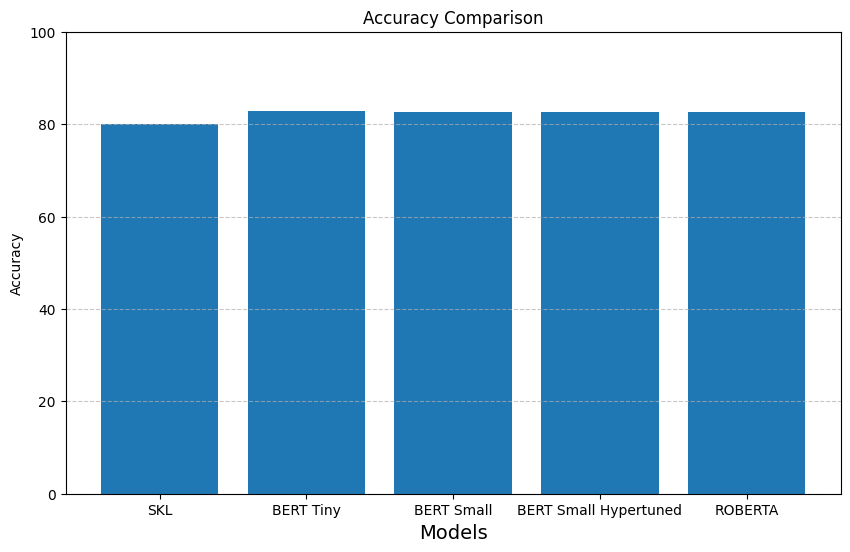

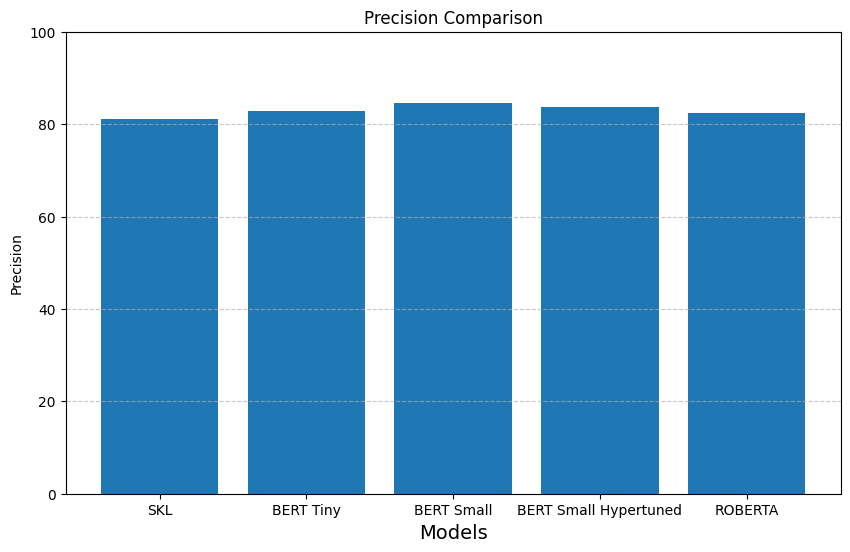

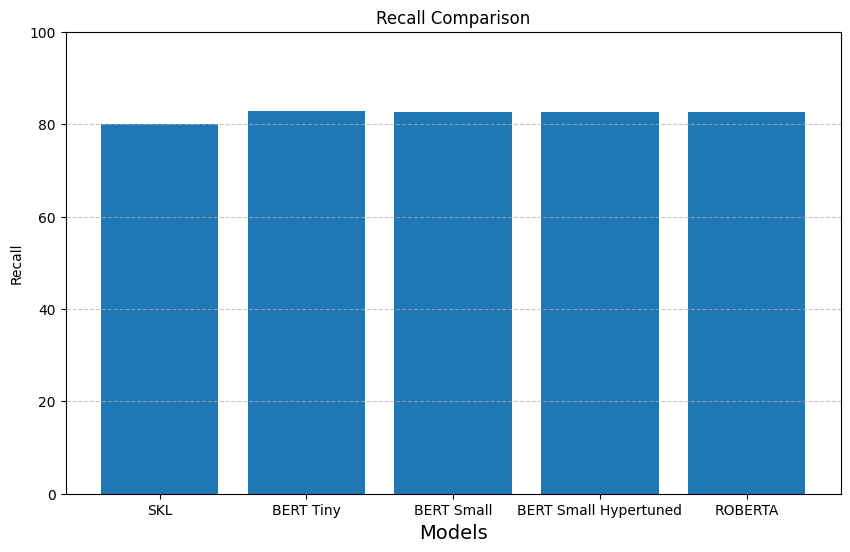

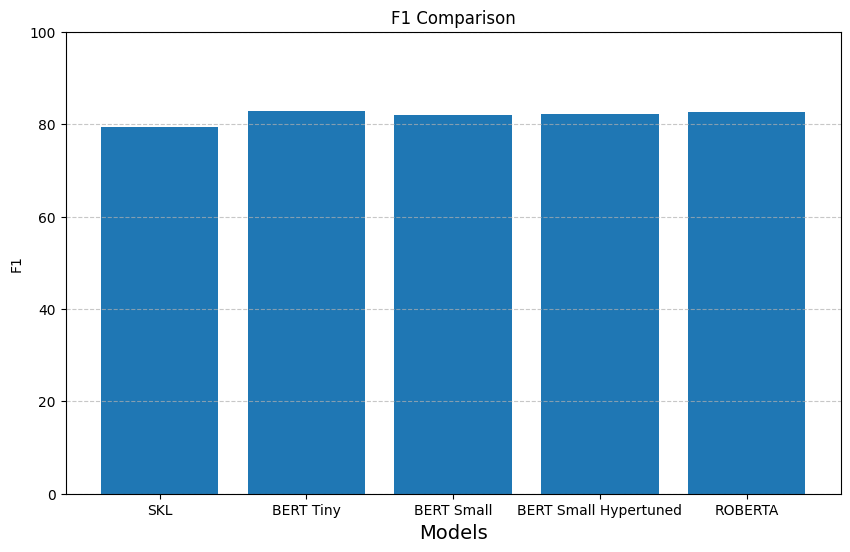

In [79]:
metrics = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    models = list(model_scores.keys())
    values = [model_scores[model][metric] for model in models]

    if metric != 'accuracy':
      plt.bar(models, [val * 100 for val in values])
      plt.ylim(0, 100)
    else:
      plt.bar(models, values)
      plt.ylim(0, 1)

    plt.title(f'{metric.capitalize()} Comparison')
    plt.xlabel('Models', fontsize=14)
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

>While all of the deep learning models outperform the SKL model, their metrics are very similar. Given that BERT Tiny is slightly outperforming the rest and it by far trains the fastest, I judge it as the best model so far. This because despite its metrics being very comparable to the other deep learning models, its small size makes for the fastest training and deployment times.

## Analyzing Predictions

>Lets take a closer look at the predictions the BERT Tiny model is making. Perhaps some patterns can be seen in the false positives and false negatives?

In [80]:
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_1.keras')

model_1_preds = make_preds("model_1.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
{'accuracy': 82.9284307288247, 'precision': 0.8293444618354476, 'recall': 0.8292843072882469, 'f1': 0.8279800884040511}


In [109]:
preds = model_1.predict(X_val)

preds

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


array([[ 0.84594065, -0.8800209 ],
       [ 1.2226392 , -1.2067604 ],
       [-0.5496373 ,  0.65258753],
       ...,
       [-0.6204264 ,  0.64406586],
       [-1.6154093 ,  1.6543342 ],
       [ 0.4563912 , -0.49193195]], dtype=float32)

In [110]:
# Apply softmax to logits
probabilities = np.exp(preds) / np.sum(np.exp(preds), axis=1, keepdims=True)

probabilities


array([[0.84889513, 0.15110487],
       [0.91904193, 0.08095813],
       [0.23107968, 0.76892036],
       ...,
       [0.22020152, 0.77979845],
       [0.03662388, 0.96337616],
       [0.7207778 , 0.27922222]], dtype=float32)

In [111]:
import numpy as np

def analyze_predictions(model, X_val, y_val):
    """
    Analyzes the predictions made by a given model on the validation set.

    Parameters:
    - model: A trained machine learning model capable of making predictions.
    - X_val: The validation set features.
    - y_val: The true labels corresponding to the validation set.

    Returns:
    - true_positives_data: A list of tuples containing text data and confidence levels for true positives.
    - true_negatives_data: A list of tuples containing text data and confidence levels for true negatives.
    - false_positives_data: A list of tuples containing text data and confidence levels for false positives.
    - false_negatives_data: A list of tuples containing text data and confidence levels for false negatives.
    """

    # Obtain raw logits from the model
    logits = model.predict(X_val)

    # Apply softmax to obtain probabilities
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

    # Get predicted classes
    preds_binary = np.argmax(probabilities, axis=1)

    # Get confidence scores
    confidences = np.max(probabilities, axis=1)

    # Determine true positives, true negatives, false positives, and false negatives
    true_positives = (preds_binary == 1) & (y_val == 1)
    true_negatives = (preds_binary == 0) & (y_val == 0)
    false_positives = (preds_binary == 1) & (y_val == 0)
    false_negatives = (preds_binary == 0) & (y_val == 1)

    # Extract data for each category
    true_positives_data = list(zip(X_val[true_positives], confidences[true_positives]))
    true_negatives_data = list(zip(X_val[true_negatives], confidences[true_negatives]))
    false_positives_data = list(zip(X_val[false_positives], confidences[false_positives]))
    false_negatives_data = list(zip(X_val[false_negatives], confidences[false_negatives]))

    return true_positives_data, true_negatives_data, false_positives_data, false_negatives_data

In [116]:
true_positives_data, true_negatives_data, false_positives_data, false_negatives_data = analyze_predictions(model_1, X_val, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [117]:
print("\nFalse Positives:")
for text, confidence in false_positives_data[:5]:  # Print the first 5 false positives along with confidence
    print(text, confidence)


False Positives:
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE 0.8982444
@BloopAndABlast Because I need to know if I'm supposed to throw myself off a bridge for a #Collapse or plan the parade. There is no both 0.74497175
she's a suicide bomb 0.5841506
@raineishida lol...Im just a nervous wreck :P 0.68768275
Sitting still in the #CityofMemphis traffic is like sitting in a war zone! They don't move for the Police.. They don't care 0.83881044


In [118]:
def visualize_prediction_card(text, confidence, correct, predicted_label=None):
    """
    Visualizes a prediction card with text, confidence score, predicted label, and correctness.

    Parameters:
    - text: The text data of the prediction.
    - confidence: The confidence score of the prediction.
    - correct: Boolean indicating whether the prediction was correct or not.
    - predicted_label: The label predicted by the model (optional).
    """
    # Define colors based on correctness
    color = 'green' if correct else 'red'

    # Create the card-like visualization
    plt.figure(figsize=(8, 4))
    # Box for the tweet text
    plt.text(0.1, 0.75, text, fontsize=12, ha='left', va='top', wrap=True, bbox=dict(facecolor='#1DA1F2', edgecolor='#1DA1F2', boxstyle='round,pad=0.5'))
    # Predicted label
    plt.text(0.5, 0.45, f"Predicted: {predicted_label}", fontsize=10, ha='center', va='center', wrap=True)
    # Confidence score
    plt.text(0.5, 0.35, f"Confidence: {confidence:.2f}", fontsize=10, ha='center', va='center', wrap=True)
    # Correctness indicator
    plt.text(0.5, 0.25, "Correct" if correct else "Incorrect", fontsize=10, ha='center', va='center', wrap=True, color=color)
    plt.axis('off')
    plt.show()


True Positives:


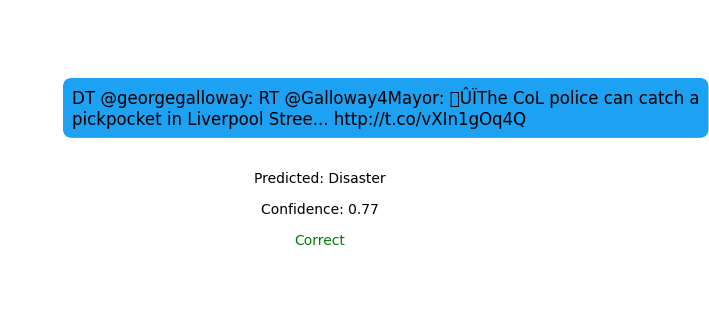

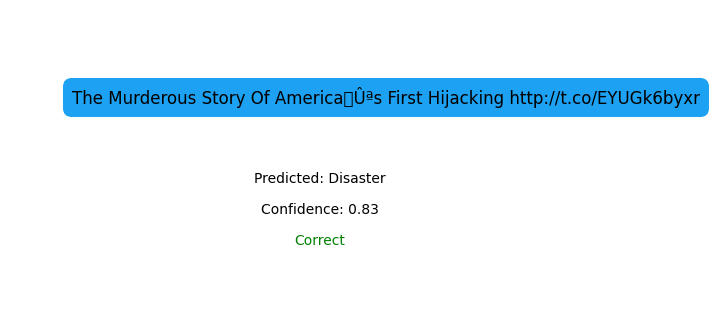

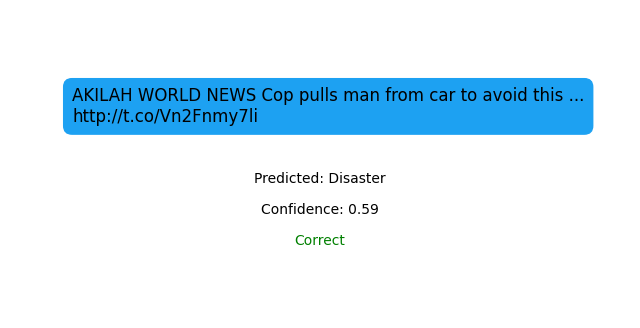

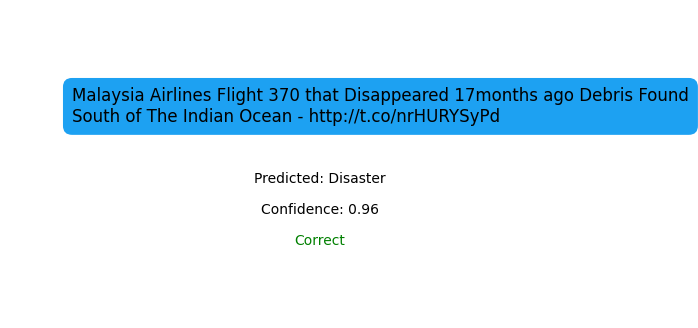

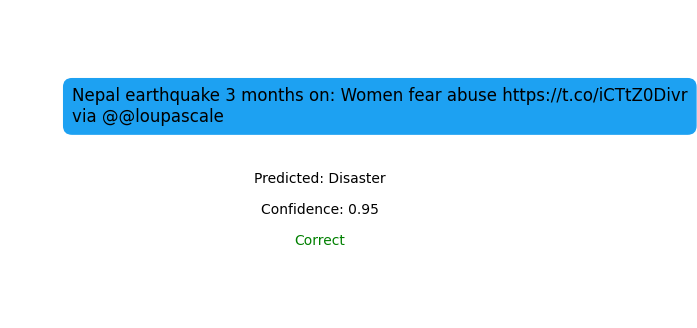

True Negatives:


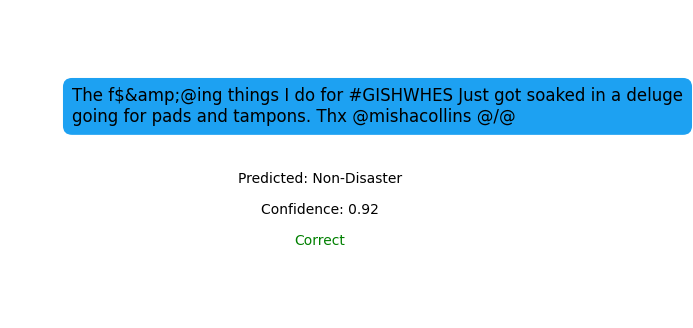

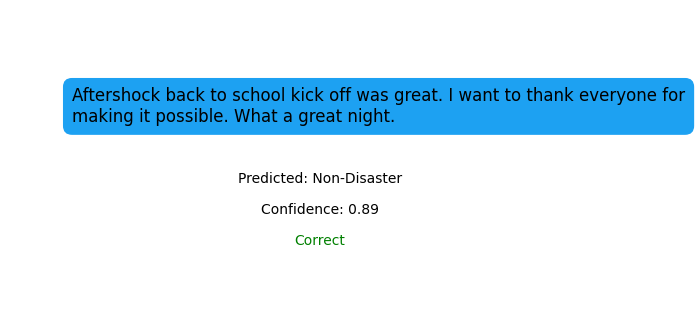

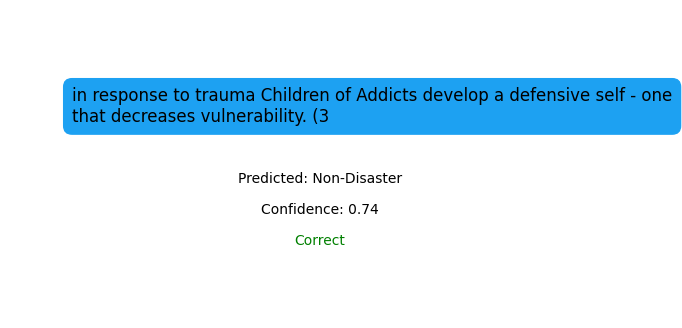

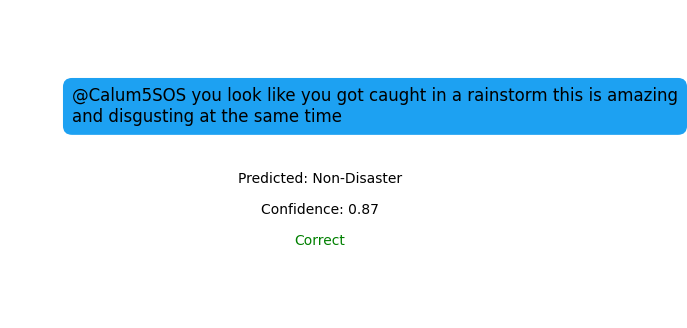

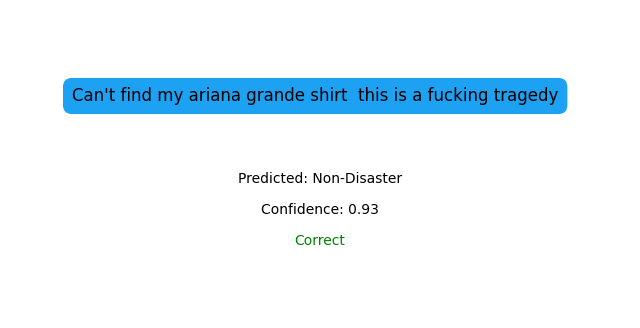

False Positives:


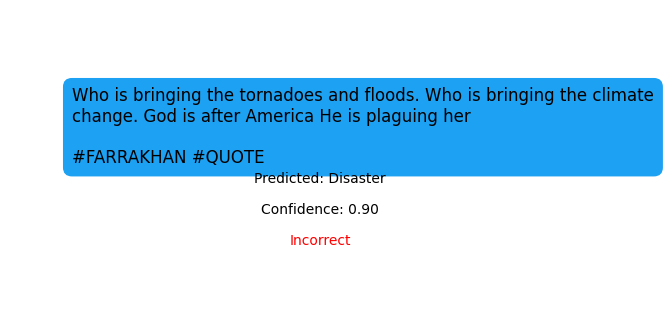

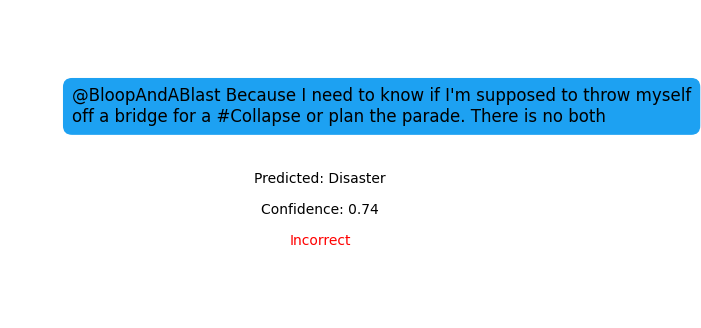

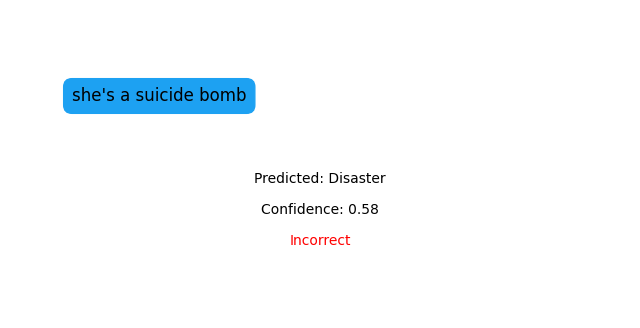

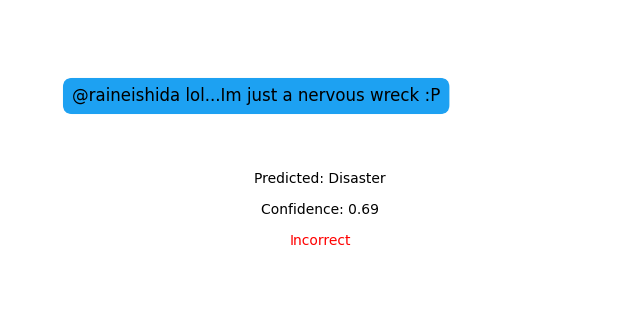

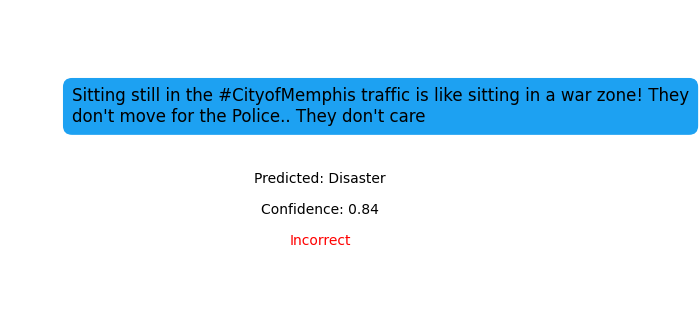

False Negatives:


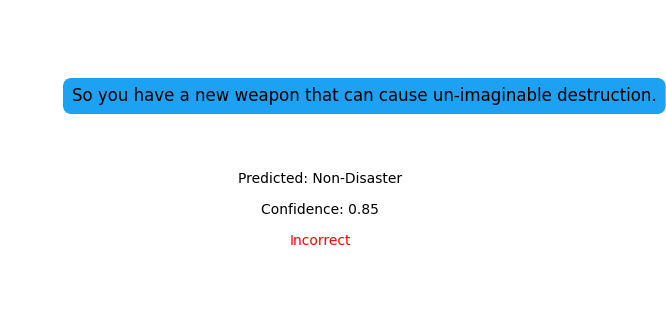

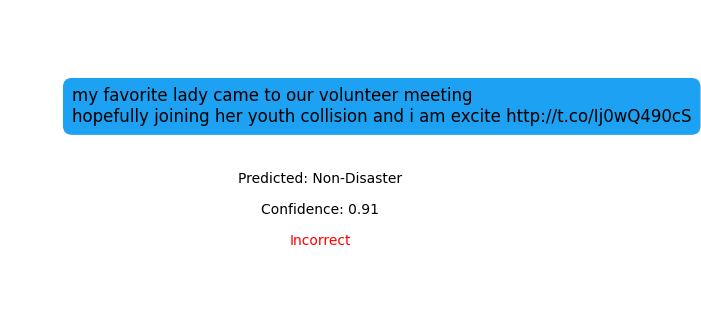

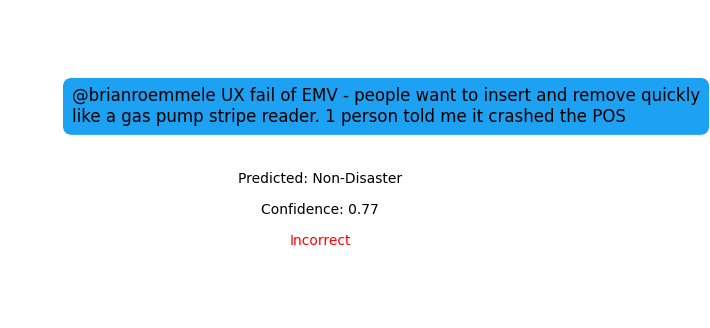

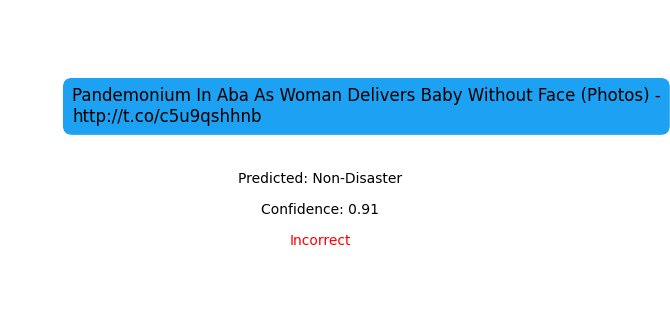

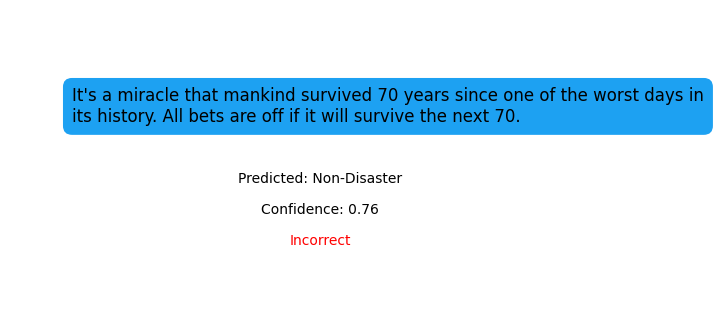

In [122]:
for data, category in [(true_positives_data, "True Positives"), (true_negatives_data, "True Negatives"),
                       (false_positives_data, "False Positives"), (false_negatives_data, "False Negatives")]:
    print(f"{category}:")
    for i, (text, confidence) in enumerate(data[:5]):
        correct = (category.startswith("True") and category != "True Negatives") or (category == "True Negatives")
        predicted_label = "Disaster" if category.startswith("True") else "Non-Disaster"
        if category == "True Negatives":
          predicted_label = "Non-Disaster"
        elif category == "False Positives":
          predicted_label = "Disaster"
        visualize_prediction_card(text, confidence, correct, predicted_label)


>Lets take a closer look at some of the false positives and false negatives to see where this model is getting confused. I will start by analyzing the false positives, lets take a look at the 5 most confident and least confident false positive predictions.

Top 5 Most Confident False Positives:


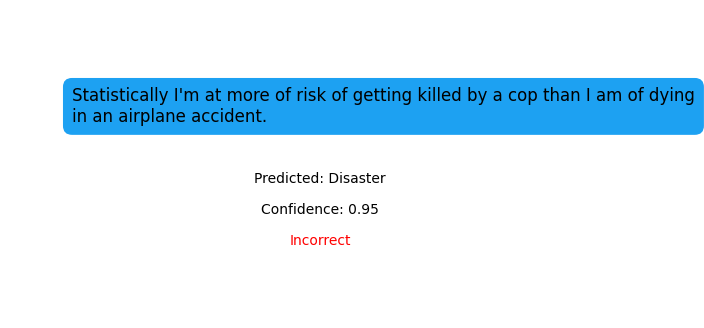

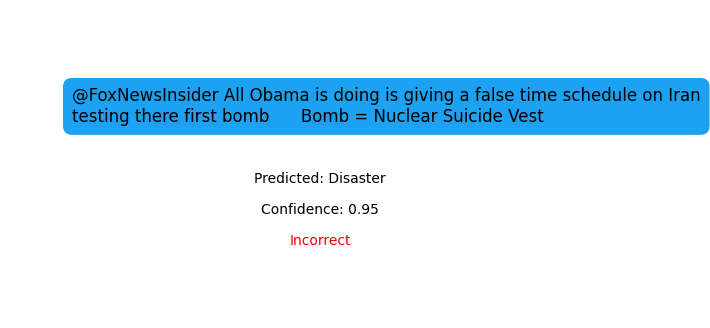

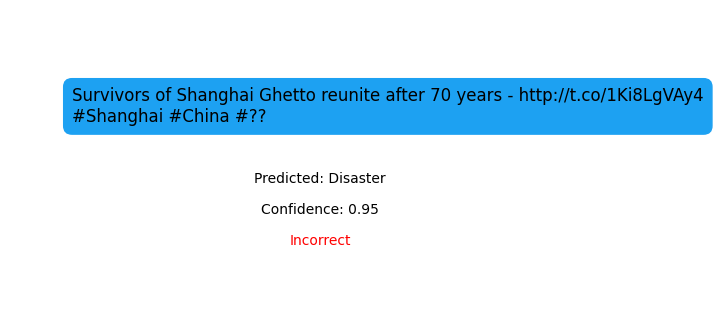

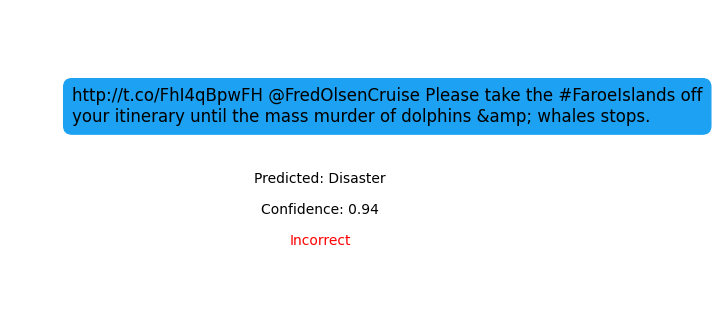

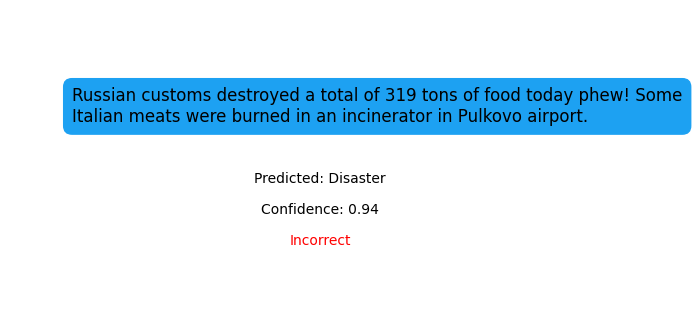

In [123]:
# Sort false positives data by confidence level
false_positives_data_sorted = sorted(false_positives_data, key=lambda x: x[1], reverse=True)

# Top 5 most confident false positives
print("Top 5 Most Confident False Positives:")
for i, (text, confidence) in enumerate(false_positives_data_sorted[:5]):
    correct = False  # Since these are false positives
    predicted_label = "Disaster"  # Since these are false positives
    visualize_prediction_card(text, confidence, correct, predicted_label)

>It seems that the model is struggling with context. It has learned to associate words like "dying", "survivor", and "bomb" with disasters, and these tweets are using them in a non-disaster context. Perhaps enriching the training data with examples of tweets which use hyperbolic langauge about political events could result in a more accurate model that learns these words do not always mean a disaster has happened?

>Lets see the least confident false positives now.

Top 5 Least Confident False Positives:


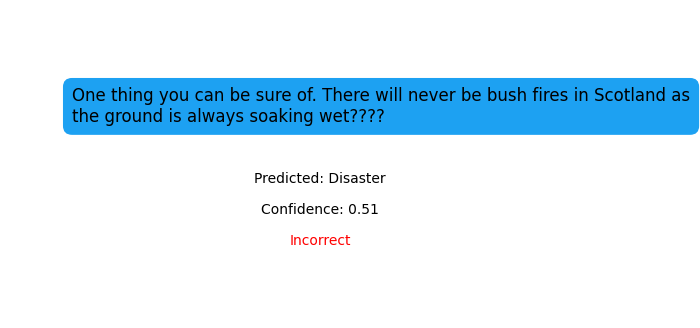

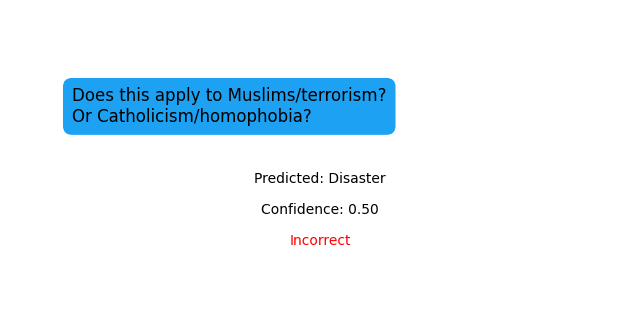

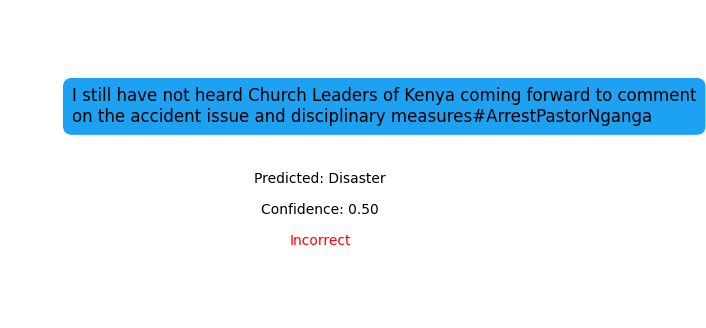

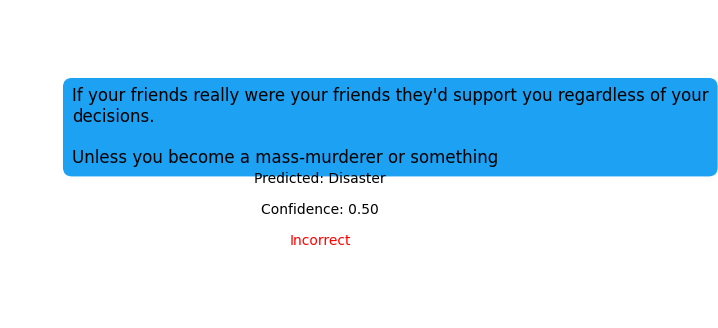

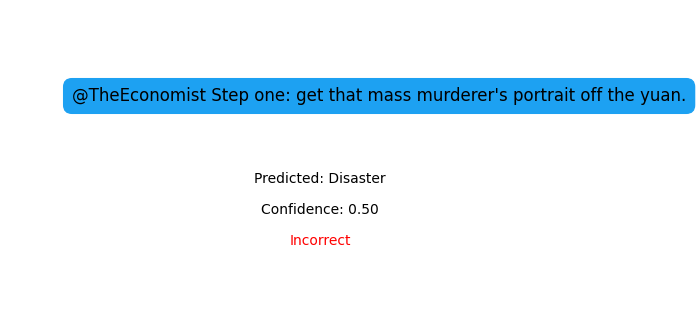

In [125]:
# Top 5 most confident false positives
print("Top 5 Least Confident False Positives:")
for i, (text, confidence) in enumerate(false_positives_data_sorted[-5:]):
    correct = False  # Since these are false positives
    predicted_label = "Disaster"  # Since these are false positives
    visualize_prediction_card(text, confidence, correct, predicted_label)

>I am once again noticing that a lot of these false positives are coming from political tweets. Still, it seems to be on the cusp of declaring these particular tweets as not being about disasters. Perhaps the language they use is a little less extreme than in the most confident false positives? Still, adding politically charged tweets to the training seems like it would be a good start in trying to improve the model. That seems to be the model's greatest stumbling point.

>Now, lets look at the most and least confident false negatives.

Top 5 Most Confident False Negatives:


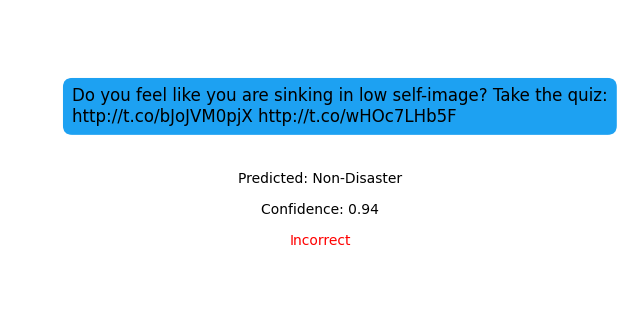

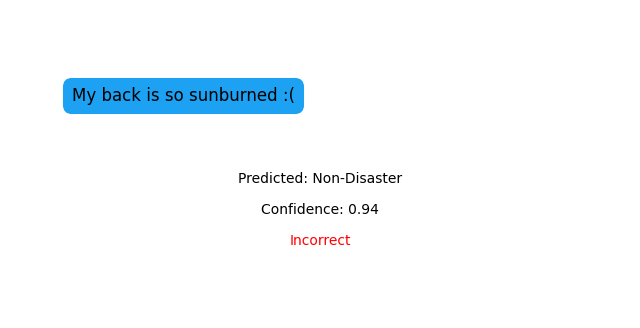

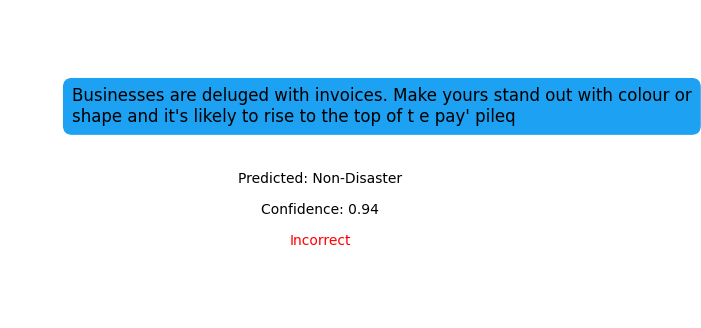

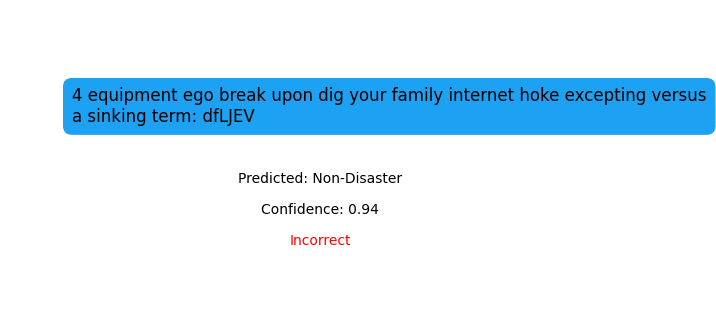

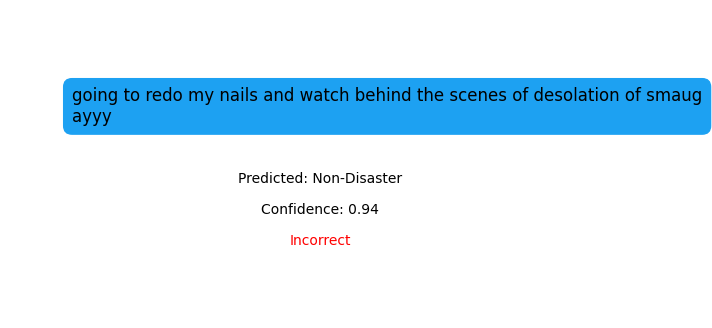

In [128]:
# Sort false nagatives data by confidence level
false_nagatives_data_sorted = sorted(false_negatives_data, key=lambda x: x[1], reverse=True)

# Top 5 most confident false negatives
print("Top 5 Most Confident False Negatives:")
for i, (text, confidence) in enumerate(false_nagatives_data_sorted[:5]):
    correct = False  # Since these are false positives
    predicted_label = "Non-Disaster"  # Since these are false positives
    visualize_prediction_card(text, confidence, correct, predicted_label)

>Interesting! It seems to me that this reflects the dataset itself contains errors. For most people redoing your nails, getting a sunburn, and a quiz about low-self esteem are not disasters, but they have been classified as such in the training data! This means the model may actually be more accurate at classifying non-disaster tweets than the current accuracy metrics are displaying.

>Now lets take a look at the least confident false negatives.

Top 5 Least Confident False Negatives:


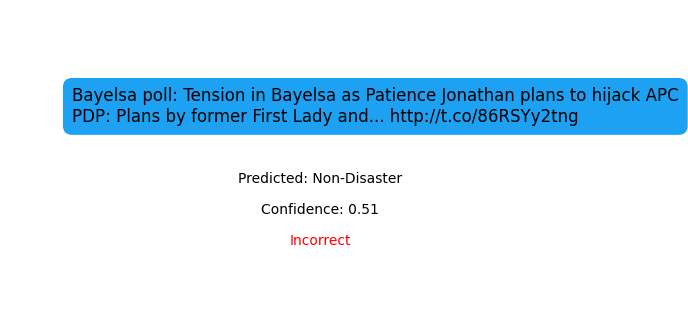

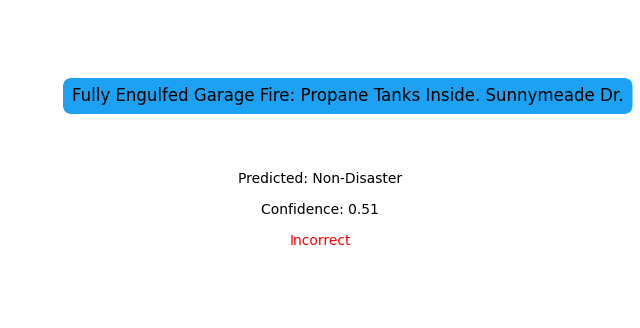

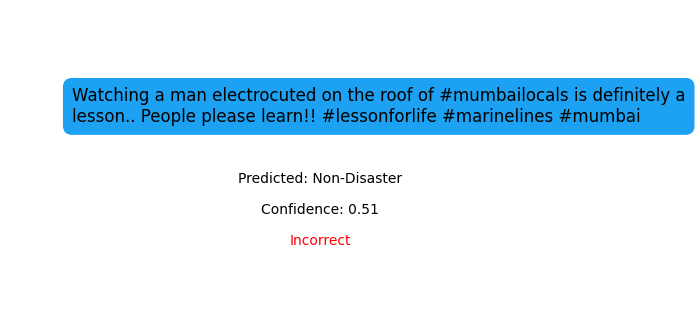

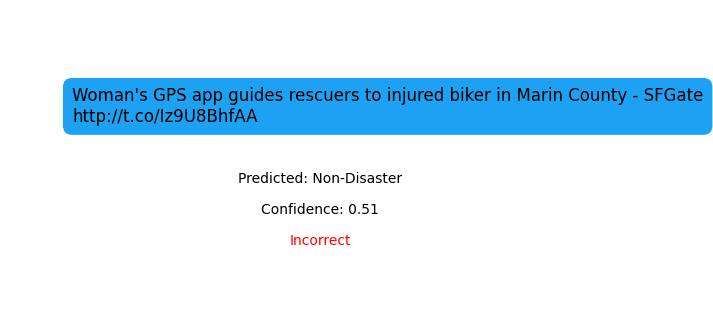

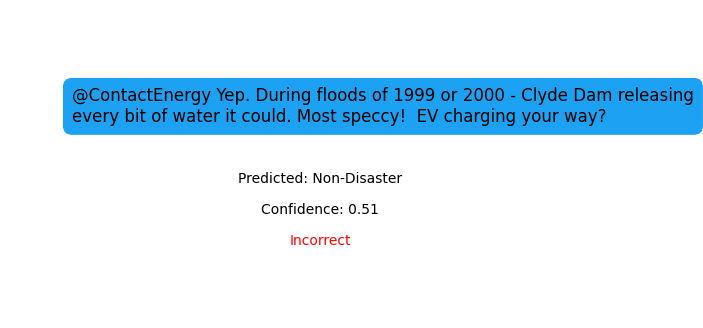

In [129]:
# Top 5 least confident false positives
print("Top 5 Least Confident False Negatives:")
for i, (text, confidence) in enumerate(false_nagatives_data_sorted[-5:]):
    correct = False  # Since these are false positives
    predicted_label = "Non-Disaster"  # Since these are false positives
    visualize_prediction_card(text, confidence, correct, predicted_label)

>These tweets seem to be classified better in the training data. It is not entirely clear why it leans slightly towards identifying these as non-disaster tweets. Despite actually being about disasters, I notice the tweets use less harsh adjectives than some of the political tweets from the false positive section. This may be throwing the model off a bit.

## Exporting predictions

In [ ]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_1.keras')

preds = best_model.predict(test["text"])

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 148 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step


In [ ]:
preds = np.argmax(preds, axis=1)

In [ ]:
df = pd.DataFrame({"id": test.index, "target": preds})

df.to_csv('predictions.csv', index=False)

## Conclusion

>After building these models, it appears the Tiny BERT model is the most ideal. While it has comparable metrics to the other deep learning models, its small sizes gives it an edge in prediction speed and deployablility.

>It seems this model is getting confused by tweets about non-disasters that use hyperbolic language. This commonly shows up in political tweets which use strong language when describing the author disagrees with. I believe the model could be improved my including more charged political tweets in the training data so it can learn to tell these apart from tweets about actual disasters.

>Interestingly, the training data appears to have errors with how it classifies some tweets. As was seen in the section analyzing false negatives, some tweets in the training data are labeled as being about disasters when they do not really appear to be. This indicates a need to clean the data and ensure the labels are accurate.